# Exercices 4 - Speasy and Data Manipulation

<div align="center">
<img src="https://raw.githubusercontent.com/SciQLop/speasy/main/logo/logo_speasy.svg"/>
</div>

In [53]:
import speasy as spz
import matplotlib.pyplot as plt
%matplotlib widget

# Data manipulation

Speasy is a package essentially meant to ease data access.\
But it also provides basic features that are generally and quickly handy once data has arrived


## Fill values

In cases there is an instrument problem or data is missing, products often fill values with some obviously abnormal value such as 1e30.
Speasy provides a way to quickly transform fill values into NaNs, so they do not appear on plots or computations.<br/>


The following cell downloads data during an interval where there are fill values.\
Plotting the data makes it obvious fill values are a problem.


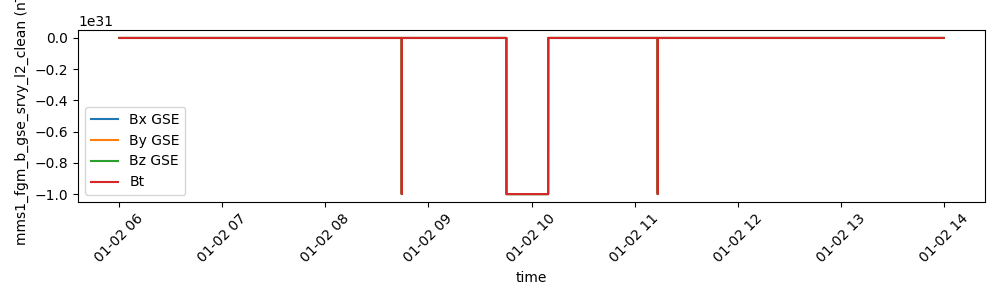

In [10]:
cda  = spz.inventories.data_tree.cda
start_date = "2019-01-02 06:00"
stop_date = "2019-01-02 14:00"

fig = plt.figure(figsize=(10,3))
mms1_fgm_b_gse_srvy = spz.get_data(cda.MMS.MMS1.FGM.MMS1_FGM_SRVY_L2.mms1_fgm_b_gse_srvy_l2_clean, 
                                   start_date,
                                   stop_date)
mms1_fgm_b_gse_srvy.plot()
plt.tight_layout()
plt.show()

Now write code so to produce the following figure where all the fill values have been replaced by *NaNs*

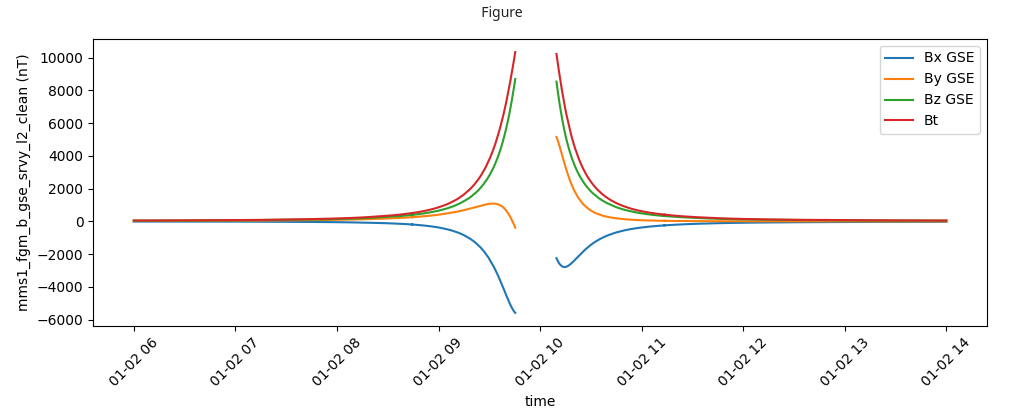

In [11]:
#
#
#
# your code here 
# mms1_fgm_b_gse_srvy_noFillVal =  ....
#
#
#

In [12]:
# Answer : 
# --------
mms1_fgm_b_gse_srvy_noFillVal =  mms1_fgm_b_gse_srvy.replace_fillval_by_nan()

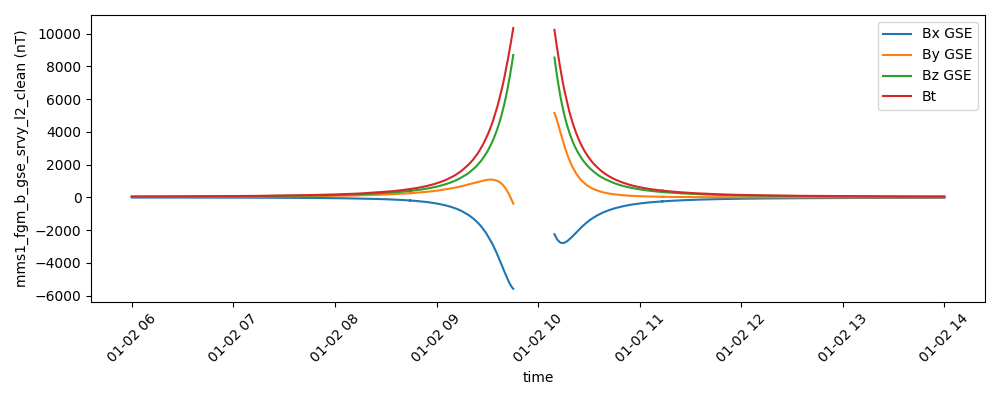

In [13]:
fig, ax = plt.subplots(figsize=(10,4))
mms1_fgm_b_gse_srvy_noFillVal.plot()
plt.tight_layout()

# Resampling and interpolation

The goal here is to manipulate a bit `SpeasyVariables` together so to make new ones by computing formulae.\
We will compute the mirror instability threshold from MMS data during an interval where MMS is about to cross the magnetopause\
during a northward IMF condition.


The mirror instability threshold formula is:

$$ C = \beta_\perp\left(\frac{T_\perp}{T_{\parallel}}-1\right)$$ 


where :

$$\beta_\perp = \frac{2\mu_0P_\perp}{B^2}$$


For this exercice you will need the following products on the CDA provider: 

- spz.inventories.data_tree.cda.MMS.MMS1.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_temppara_fast
- spz.inventories.data_tree.cda.MMS.MMS1.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_tempperp_fast
- spz.inventories.data_tree.cda.MMS.MMS1.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_numberdensity_fast
- spz.inventories.data_tree.cda.MMS.MMS1.FGM.MMS1_FGM_SRVY_L2.mms1_fgm_b_gse_srvy_l2


In [52]:
from datetime import datetime
import numpy as np
from speasy.signal.resampling import interpolate
import scipy.constants as cst


start, stop = datetime(2015, 11, 19, 13, 0), datetime(2015, 11, 19, 15, 0)

In [74]:
#
#
#
#  YOUR CODE HERE
#
#
# tpara, tperp, b, n = ......
#
#
#
#
# mirror = .... # this variable holds the mirror value threshold

In [54]:
# ANSWER
# ------

mms1_products = spz.inventories.data_tree.cda.MMS.MMS1

products = [mms1_products.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_temppara_fast,
            mms1_products.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_tempperp_fast,
            mms1_products.FGM.MMS1_FGM_SRVY_L2.mms1_fgm_b_gse_srvy_l2,
            mms1_products.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_numberdensity_fast]


tpara, tperp, b, n = spz.get_data(products, start, stop)


anisotropy = tperp/tpara
Pperp = tperp*n*1e6 
Ppara = tpara * n*1e6
b = interpolate(tperp, b)
betaperp = Pperp*cst.mu_0*cst.e*2/(b["Bt"]*1e-9)**2
mirror = betaperp * (anisotropy-1)

Now use the following function to plot the event, the expected figure is:

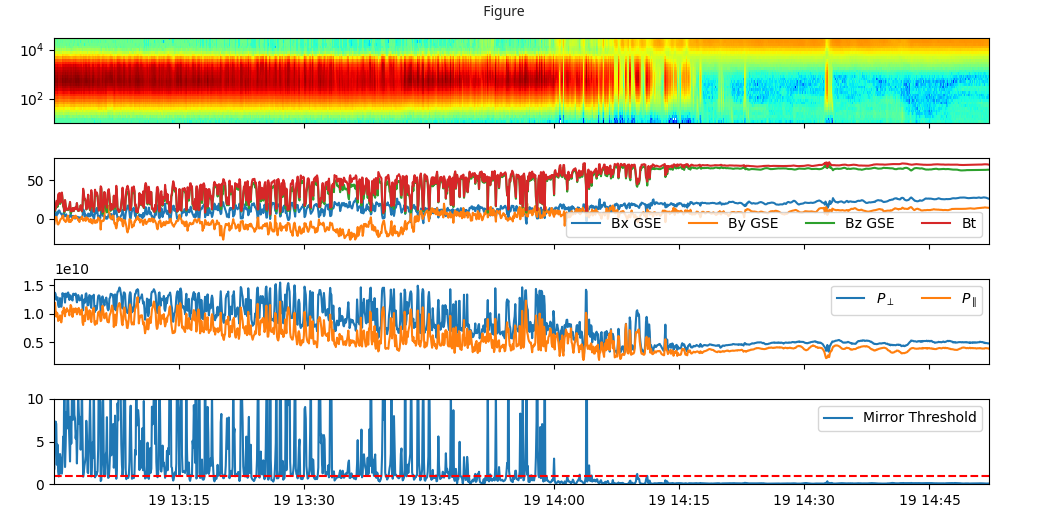

In [57]:

def plot_event(b, Pperp, Ppara, mirror):
    """
    Parameters:

    b     : SpeasyVariable, magnetic field product
    Ppara : SpeasyVariable, parallel pressure
    Pperp : SpeasyVariable, perpendicular pressure
    mirror: SpeasyVariable, mirror mode threshold
    """
    
    import matplotlib.pyplot as plt
    %matplotlib widget
    from matplotlib.colors import LogNorm
    from scipy.ndimage import gaussian_filter1d as gf
    
    spectro = spz.get_data(mms1_products.DIS.MMS1_FPI_FAST_L2_DIS_MOMS.mms1_dis_energyspectr_omni_fast, start, stop)
    
    fig, axes = plt.subplots(nrows=4, figsize=(10,5), sharex=True)
    
    
    axes[0].pcolormesh(spectro.time,
                       spectro.axes[1].values[0,:],
                       spectro.values.T, cmap="jet", norm=LogNorm())
    axes[0].set_yscale("log")
    
    axes[1].plot(b.time, b.values, label=b.columns)
    axes[2].plot(Pperp.time, Pperp.values, label = r"$P_\perp$")
    axes[2].plot(Ppara.time, Ppara.values, label = r"$P_\parallel$")
    axes[3].plot(mirror.time, mirror.values, label = "Mirror Threshold")
    axes[3].axhline(1, ls="--", color="r")
    axes[3].set_ylim((0,10))
    for ax in axes[1:]:
        ax.legend(ncol=4, loc="best")
    
    
    fig.tight_layout()

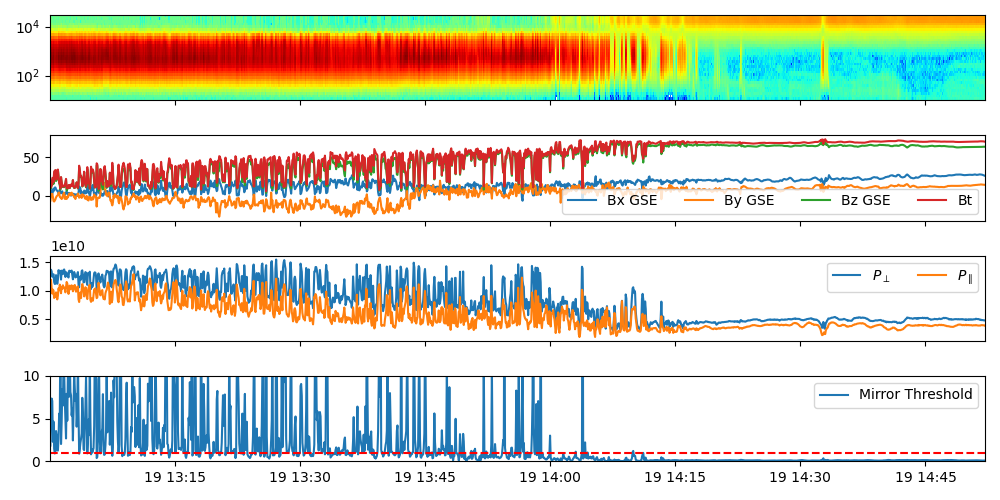

In [56]:
plot_event(b, Pperp, Ppara, mirror)